<a href="https://colab.research.google.com/github/Vasundhara1110/Shadowfox/blob/main/Infosys_project_milestone_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:

df = pd.read_csv("/content/USA_ACCIDENTS.csv")

print("Shape:", df.shape)
print("Columns:", df.columns)
print(df.head())


Shape: (83979, 8)
Columns: Index(['Unnamed: 0', 'ID', 'Start_Time', 'Start_Lat', 'Start_Lng', 'City',
       'State', 'Temperature(F)'],
      dtype='object')
   Unnamed: 0   ID           Start_Time  Start_Lat  Start_Lng          City  \
0           0  A-1  2016-02-08 05:46:00  39.865147 -84.058723        Dayton   
1           1  A-2  2016-02-08 06:07:59  39.928059 -82.831184  Reynoldsburg   
2           2  A-3  2016-02-08 06:49:27  39.063148 -84.032608  Williamsburg   
3           3  A-4  2016-02-08 07:23:34  39.747753 -84.205582        Dayton   
4           4  A-5  2016-02-08 07:39:07  39.627781 -84.188354        Dayton   

  State  Temperature(F)  
0    OH            36.9  
1    OH            37.9  
2    OH            36.0  
3    OH            35.1  
4    OH            36.0  


Shape: (83979, 8)
Columns: ['Unnamed: 0', 'ID', 'Start_Time', 'Start_Lat', 'Start_Lng', 'City', 'State', 'Temperature(F)']
   Unnamed: 0   ID           Start_Time  Start_Lat  Start_Lng          City  \
0           0  A-1  2016-02-08 05:46:00  39.865147 -84.058723        Dayton   
1           1  A-2  2016-02-08 06:07:59  39.928059 -82.831184  Reynoldsburg   
2           2  A-3  2016-02-08 06:49:27  39.063148 -84.032608  Williamsburg   
3           3  A-4  2016-02-08 07:23:34  39.747753 -84.205582        Dayton   
4           4  A-5  2016-02-08 07:39:07  39.627781 -84.188354        Dayton   

  State  Temperature(F)  
0    OH            36.9  
1    OH            37.9  
2    OH            36.0  
3    OH            35.1  
4    OH            36.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83979 entries, 0 to 83978
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      83979 non-null  int64  
 1 

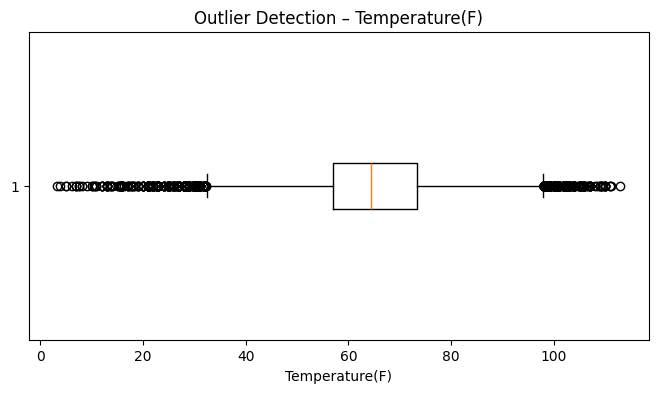

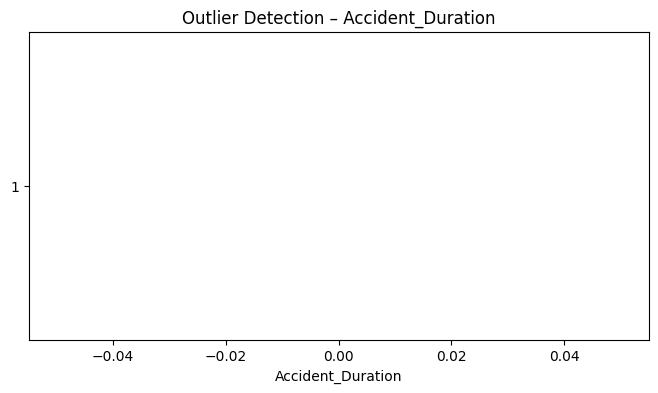

IQR capping applied. Values capped per column: {'Temperature(F)': 1136, 'Accident_Duration': 0}
Duplicates before: 0
Duplicates after: 0
Top 10 columns with missing values:
                    Missing      %
Accident_Duration    83979  100.0
Unnamed: 0               0    0.0
Start_Time               0    0.0
ID                       0    0.0
Start_Lng                0    0.0
City                     0    0.0
State                    0    0.0
Start_Lat                0    0.0
Temperature(F)           0    0.0
Year                     0    0.0
Final shape: (83979, 16)
   Year  Month  DayOfWeek  Hour  Is_Weekend  Accident_Duration
0  2016      2          0     5           0                NaN
1  2016      2          0     6           0                NaN
2  2016      2          0     6           0                NaN
3  2016      2          0     7           0                NaN
4  2016      2          0     7           0                NaN
Saved -> accidents_clean_v2.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/USA_ACCIDENTS.csv")

# Basic info
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())
print(df.info())

# Missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df)) * 100
missing_summary = pd.DataFrame({'Missing Values': missing, 'Percentage': missing_percent})
print(missing_summary.head(20))

# Drop columns with more than 50% missing data
threshold = 50
cols_to_drop = missing_summary[missing_summary['Percentage'] > threshold].index
df = df.drop(columns=cols_to_drop)
print("Dropped columns:", cols_to_drop.tolist())

# Fill missing values
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        if df[col].isnull().all():
            # If all values are missing, drop the column
            df = df.drop(columns=[col])
        else:
            df[col] = df[col].fillna(df[col].mode()[0])

# Convert datetime columns
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
if 'End_Time' in df.columns:
    df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Drop rows where Start_Time is missing
df = df.dropna(subset=['Start_Time'])

# Time-based features
df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month
df['DayOfWeek'] = df['Start_Time'].dt.dayofweek  # 0=Monday
df['Hour'] = df['Start_Time'].dt.hour
df['Is_Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Accident Duration (in minutes)
if 'End_Time' in df.columns:
    df['Accident_Duration'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60
    # Drop negative durations
    df = df[df['Accident_Duration'] >= 0]
else:
    df['Accident_Duration'] = np.nan

# Clean City and State
df['City'] = df['City'].astype(str).str.strip().str.replace(r'\s+', ' ', regex=True).str.lower()
df['State'] = df['State'].astype(str).str.strip().str.replace(r'\s+', ' ', regex=True).str.upper()

# Encode City and State
df['City_code'] = pd.factorize(df['City'])[0]
df['State_code'] = pd.factorize(df['State'])[0]

# Show encoded samples
print("Categorical cleaning done. Sample:")
print(df[['City', 'State', 'City_code', 'State_code']].head())

# Boxplots for numeric columns
numeric_cols = [c for c in ['Temperature(F)', 'Accident_Duration'] if c in df.columns]

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f"Outlier Detection – {col}")
    plt.xlabel(col)
    plt.show()

# Apply IQR capping
def iqr_cap(s, k=1.5):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return s.clip(lower, upper)

changed_counts = {}
for col in numeric_cols:
    before = df[col].copy()
    df[col] = iqr_cap(df[col])
    changed_counts[col] = int(((before != df[col]) & before.notna()).sum())

print("IQR capping applied. Values capped per column:", changed_counts)

# Drop duplicates
print("Duplicates before:", df.duplicated().sum())
df = df.drop_duplicates()
print("Duplicates after:", df.duplicated().sum())

# Final missing summary (top 10)
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).sort_values(ascending=False)
missing_summary = pd.concat([missing, missing_pct], axis=1).rename(columns={0:'Missing', 1:'%'})
print("Top 10 columns with missing values:\n", missing_summary.head(10))

# Final shape and sample of engineered features
print("Final shape:", df.shape)
cols_preview = ['Year', 'Month', 'DayOfWeek', 'Hour', 'Is_Weekend', 'Accident_Duration']
print(df[cols_preview].head())

# Save cleaned dataset
df.to_csv("accidents_clean_v2.csv", index=False)
print("Saved -> accidents_clean_v2.csv")

# Visualizations

# Accidents per year
accidents_per_year = df['Year'].value_counts().sort_index()
plt.figure(figsize=(8,5))
accidents_per_year.plot(kind='bar')
plt.title("Number of Accidents per Year")
plt.xlabel("Year")
plt.ylabel("Accident Count")
plt.show()



# Accidents by day of week
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
accidents_per_day = df['DayOfWeek'].value_counts().sort_index()
plt.figure(figsize=(8,5))
plt.bar(days, accidents_per_day)
plt.title("Accidents by Day of Week")
plt.xlabel("Day")
plt.ylabel("Accident Count")
plt.show()



In [ ]:
print(df.info())
df.isnull().sum().head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83979 entries, 0 to 83978
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         83979 non-null  int64         
 1   ID                 83979 non-null  object        
 2   Start_Time         83979 non-null  datetime64[ns]
 3   Start_Lat          83979 non-null  float64       
 4   Start_Lng          83979 non-null  float64       
 5   City               83979 non-null  object        
 6   State              83979 non-null  object        
 7   Temperature(F)     83979 non-null  float64       
 8   Year               83979 non-null  int32         
 9   Month              83979 non-null  int32         
 10  DayOfWeek          83979 non-null  int32         
 11  Hour               83979 non-null  int32         
 12  Is_Weekend         83979 non-null  int64         
 13  Accident_Duration  0 non-null      float64       
 14  City_c

,0
Unnamed: 0,0
ID,0
Start_Time,0
Start_Lat,0
Start_Lng,0
City,0
State,0
Temperature(F),0
Year,0
Month,0


In [ ]:
print(df.isnull().sum())

Unnamed: 0               0
ID                       0
Start_Time               0
Start_Lat                0
Start_Lng                0
City                     0
State                    0
Temperature(F)           0
Year                     0
Month                    0
DayOfWeek                0
Hour                     0
Is_Weekend               0
Accident_Duration    83979
City_code                0
State_code               0
dtype: int64


In [ ]:
print(df.describe())


         Unnamed: 0                     Start_Time     Start_Lat  \
count  83979.000000                          83979  83979.000000   
mean   41988.000107  2016-09-21 07:46:36.017551616     35.966734   
min        0.000000            2016-02-08 05:46:00     32.542587   
25%    20993.500000     2016-07-15 01:46:48.500000     34.003773   
50%    41988.000000            2016-10-06 00:33:02     36.865444   
75%    62982.500000            2016-11-29 16:31:41     37.896017   
max    83977.000000            2017-01-26 20:07:03     41.428753   
std    24242.793280                            NaN      2.125693   

          Start_Lng  Temperature(F)          Year         Month     DayOfWeek  \
count  83979.000000    83979.000000  83979.000000  83979.000000  83979.000000   
mean    -119.591226       65.375865   2016.111218      7.828100      2.555520   
min     -123.813927       32.400000   2016.000000      1.000000      0.000000   
25%     -121.931762       57.000000   2016.000000      6.000000

In [ ]:

print("Duplicates:", df.duplicated().sum())


Duplicates: 0


In [ ]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

print("Min Date:", df['Start_Time'].min())
print("Max Date:", df['Start_Time'].max())


Min Date: 2016-02-08 05:46:00
Max Date: 2017-01-26 20:07:03


In [ ]:
print("Number of states:", df['State'].nunique())
print("States:", df['State'].unique())

Number of states: 3
States: ['OH' 'WV' 'CA']


In [ ]:
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_summary = pd.DataFrame({'Missing Values': missing, 'Percentage': missing_percent})
print(missing_summary.head(20))

                   Missing Values  Percentage
Accident_Duration           83979       100.0
City                            0         0.0
City_code                       0         0.0
DayOfWeek                       0         0.0
Hour                            0         0.0
ID                              0         0.0
Is_Weekend                      0         0.0
Month                           0         0.0
Start_Lat                       0         0.0
Start_Lng                       0         0.0
Start_Time                      0         0.0
State                           0         0.0
State_code                      0         0.0
Temperature(F)                  0         0.0
Unnamed: 0                      0         0.0
Year                            0         0.0


In [ ]:
# Drop columns with too many missing values (example threshold: 50%)
threshold = 50
cols_to_drop = missing_summary[missing_summary['Percentage'] > threshold].index
df = df.drop(columns=cols_to_drop)
print("Dropped columns:", cols_to_drop.tolist())

# Fill missing numeric with median, categorical with mode
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])


Dropped columns: ['Accident_Duration']


In [ ]:
print(df.columns.tolist())


['Unnamed: 0', 'ID', 'Start_Time', 'Start_Lat', 'Start_Lng', 'City', 'State', 'Temperature(F)', 'Year', 'Month', 'DayOfWeek', 'Hour', 'Is_Weekend', 'City_code', 'State_code']


In [ ]:
# Clean City and State columns
df['City'] = df['City'].astype(str).str.lower().str.strip()
df['State'] = df['State'].astype(str).str.strip()

In [ ]:
# Ensure Start_Time exists
if 'Start_Time' in df.columns:
    df = df.dropna(subset=['Start_Time'])

    # Extract time-based features
    df['Year'] = df['Start_Time'].dt.year
    df['Month'] = df['Start_Time'].dt.month
    df['DayOfWeek'] = df['Start_Time'].dt.dayofweek  # 0=Mon, 6=Sun
    df['Hour'] = df['Start_Time'].dt.hour

    # Weekend indicator
    df['Is_Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

    # Accident duration (only if End_Time exists)
    if 'End_Time' in df.columns:
        df['Accident_Duration'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60
    else:
        df['Accident_Duration'] = None  # placeholder if missing

    print(df[['Year','Month','DayOfWeek','Hour','Is_Weekend']].head())


   Year  Month  DayOfWeek  Hour  Is_Weekend
0  2016      2          0     5           0
1  2016      2          0     6           0
2  2016      2          0     6           0
3  2016      2          0     7           0
4  2016      2          0     7           0


In [ ]:


# Clean City (lowercase) and State (uppercase)
if 'City' in df.columns:
    df['City'] = (
        df['City'].astype(str)
                  .str.strip()
                  .str.replace(r'\s+', ' ', regex=True)
                  .str.lower()
    )

if 'State' in df.columns:
    df['State'] = (
        df['State'].astype(str)
                   .str.strip()
                   .str.replace(r'\s+', ' ', regex=True)
                   .str.upper()
    )


for col in ['City', 'State']:
    if col in df.columns:
        df[col + '_code'] = pd.factorize(df[col])[0]

print("Categorical cleaning done. Sample:")
cols_to_show = [c for c in ['City','State','City_code','State_code'] if c in df.columns]
print(df[cols_to_show].head())


Categorical cleaning done. Sample:
           City State  City_code  State_code
0        dayton    OH          0           0
1  reynoldsburg    OH          1           0
2  williamsburg    OH          2           0
3        dayton    OH          0           0
4        dayton    OH          0           0


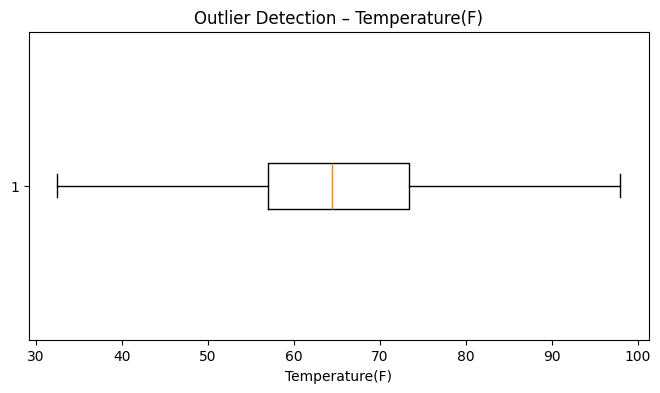

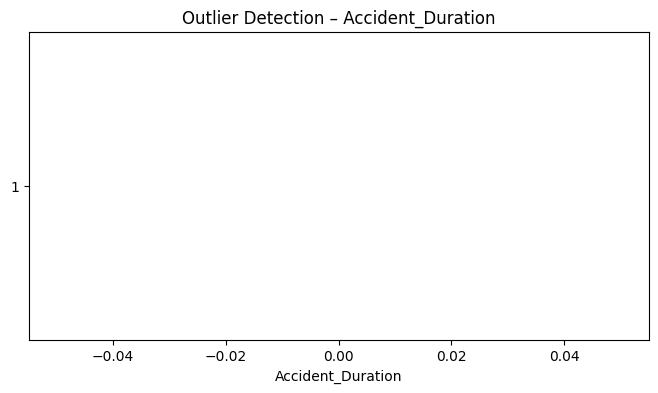

IQR capping applied. Values capped per column: {'Temperature(F)': 0, 'Accident_Duration': 0}


In [ ]:
import matplotlib.pyplot as plt


numeric_cols = [c for c in ['Temperature(F)', 'Accident_Duration'] if c in df.columns]


for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f"Outlier Detection – {col}")
    plt.xlabel(col)
    plt.show()


def iqr_cap(s, k=1.5):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return s.clip(lower, upper)

changed_counts = {}
for col in numeric_cols:
    before = df[col].copy()
    df[col] = iqr_cap(df[col])
    changed_counts[col] = int(((before != df[col]) & before.notna()).sum())

print("IQR capping applied. Values capped per column:", changed_counts)



In [ ]:
# Duplicates
print("Duplicates before:", df.duplicated().sum())
df = df.drop_duplicates()
print("Duplicates after:", df.duplicated().sum())

# Missing summary (top 10)
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_summary = (pd.concat([missing, missing_pct], axis=1)
                   .rename(columns={0:'Missing', 1:'%'}))
print("Top 10 columns with missing values:\n", missing_summary.head(10))

# Shape & preview engineered cols
print("Final shape:", df.shape)
cols_preview = [c for c in ['Year','Month','DayOfWeek','Hour','Is_Weekend','Accident_Duration'] if c in df.columns]
print(df[cols_preview].head())

# Save cleaned dataset
df.to_csv("accidents_clean_v2.csv", index=False)
print("Saved -> accidents_clean_v2.csv")


Duplicates before: 0
Duplicates after: 0
Top 10 columns with missing values:
                    Missing      %
Accident_Duration    83979  100.0
Unnamed: 0               0    0.0
Start_Time               0    0.0
ID                       0    0.0
Start_Lng                0    0.0
City                     0    0.0
State                    0    0.0
Start_Lat                0    0.0
Temperature(F)           0    0.0
Year                     0    0.0
Final shape: (83979, 16)
   Year  Month  DayOfWeek  Hour  Is_Weekend Accident_Duration
0  2016      2          0     5           0              None
1  2016      2          0     6           0              None
2  2016      2          0     6           0              None
3  2016      2          0     7           0              None
4  2016      2          0     7           0              None
Saved -> accidents_clean_v2.csv


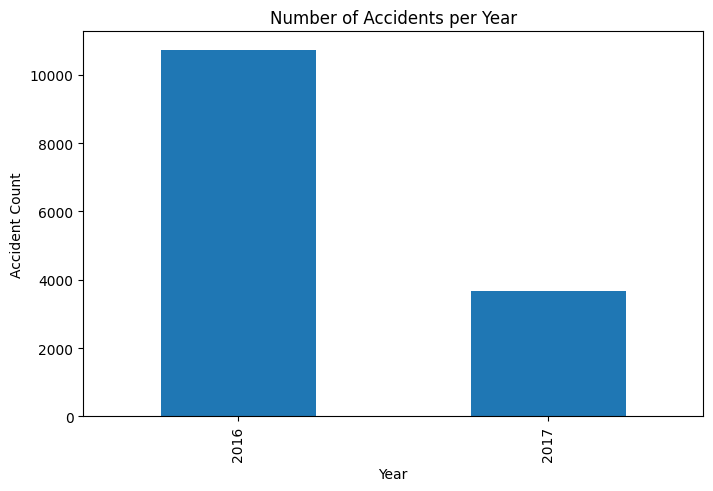

In [ ]:

accidents_per_year = df['Year'].value_counts().sort_index()

plt.figure(figsize=(8,5))
accidents_per_year.plot(kind='bar')
plt.title("Number of Accidents per Year")
plt.xlabel("Year")
plt.ylabel("Accident Count")
plt.show()


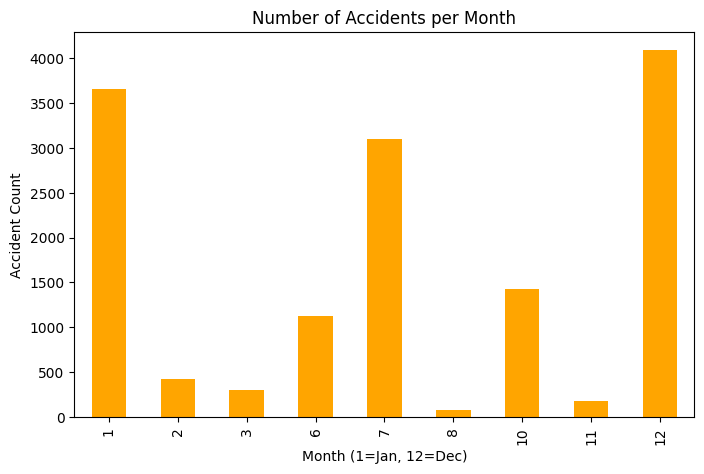

In [ ]:
accidents_per_month = df['Month'].value_counts().sort_index()

plt.figure(figsize=(8,5))
accidents_per_month.plot(kind='bar', color='orange')
plt.title("Number of Accidents per Month")
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Accident Count")
plt.show()


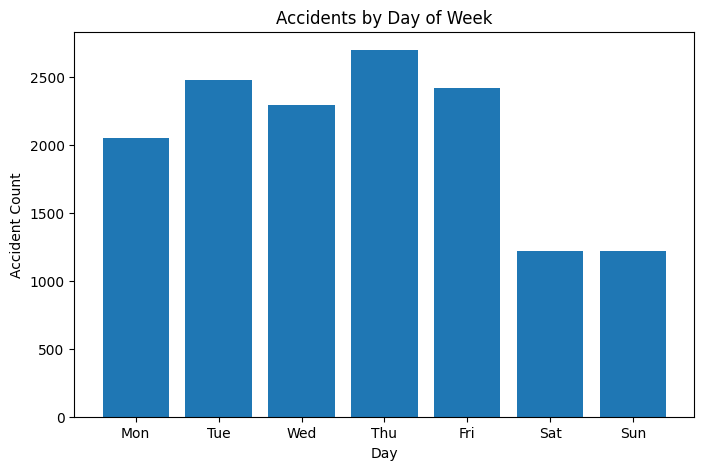

In [ ]:
days = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
accidents_per_day = df['DayOfWeek'].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(days, accidents_per_day)
plt.title("Accidents by Day of Week")
plt.xlabel("Day")
plt.ylabel("Accident Count")
plt.show()


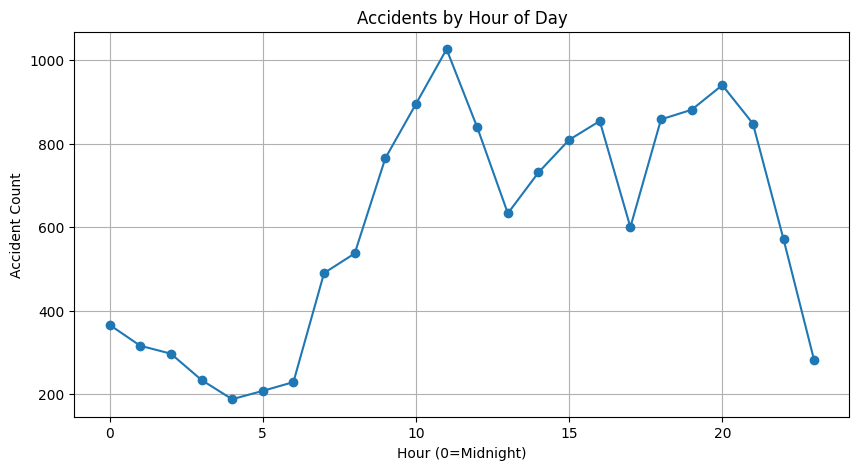

In [ ]:
accidents_per_hour = df['Hour'].value_counts().sort_index()

plt.figure(figsize=(10,5))
accidents_per_hour.plot(kind='line', marker='o')
plt.title("Accidents by Hour of Day")
plt.xlabel("Hour (0=Midnight)")
plt.ylabel("Accident Count")
plt.grid()
plt.show()
